# Order effects

Experiment 1 found order effects in the image condition: the first image block was much more variable for subjects than on the second image block and for all word blocks. Here, we are simulating these order effects to revisit the linear model formula and power analysis. 

In [ ]:
# If you have not installed `wiscs` locally, run this cell
!pip install git+https://github.com/w-decker/wiscs.git --quiet # REQUIRED FOR THIS NOTEBOOK
!pip install git+https://github.com/w-decker/rinterface.git --quiet # REQUIRED FOR THIS NOTEBOOK

In [9]:
# always run this cell, no matter which method you choose
import wiscs
from wiscs.simulate import DataGenerator
from wiscs.formula import Formula

import rinterface.rinterface as R
from rinterface.utils import to_r

import numpy as np
import pandas as pd

In [81]:
n_subject = 180
n_item = 30
n_question = 2
word_task = np.array([100, 100])
hyp = "shared"
if hyp == "shared":
    image_task = np.array([100, 100])
else:
    image_task = np.array([100, 105])

re_formula = Formula("(1 + question | subject) + (1 + question | item)")
question_sd = [10, 12, 15, 18, 11] # must be n_q - 1
params = {'word.perceptual': 100, 'image.perceptual': 95, 'word.conceptual': 100, 'image.conceptual': 100, 'word.task': word_task, 'image.task': image_task,
        # noise parameters     
        'sd.item': 40,     'sd.question': question_sd[:n_question-1],    'sd.subject': 35,       "sd.modality": 30, "sd.error": 50, "sd.re_formula": str(re_formula),
        # correlations among random effects    
        "corr.subject": np.eye(n_question), 'corr.item':np.eye(n_question),
        # design parameters
        'n.subject': n_subject, 'n.question': n_question, 'n.item': n_item
}
wiscs.set_params(params, verbose=False)

DG = DataGenerator()
DG.fit_transform(seed=2027, verbose=False)

In [82]:
df = DG.to_pandas()
df.head(15)
df.to_csv("wiscs_data.csv", index=False)

## What do no order effects look like?

Below is a subset of subject's reaction times _without_ order effects.

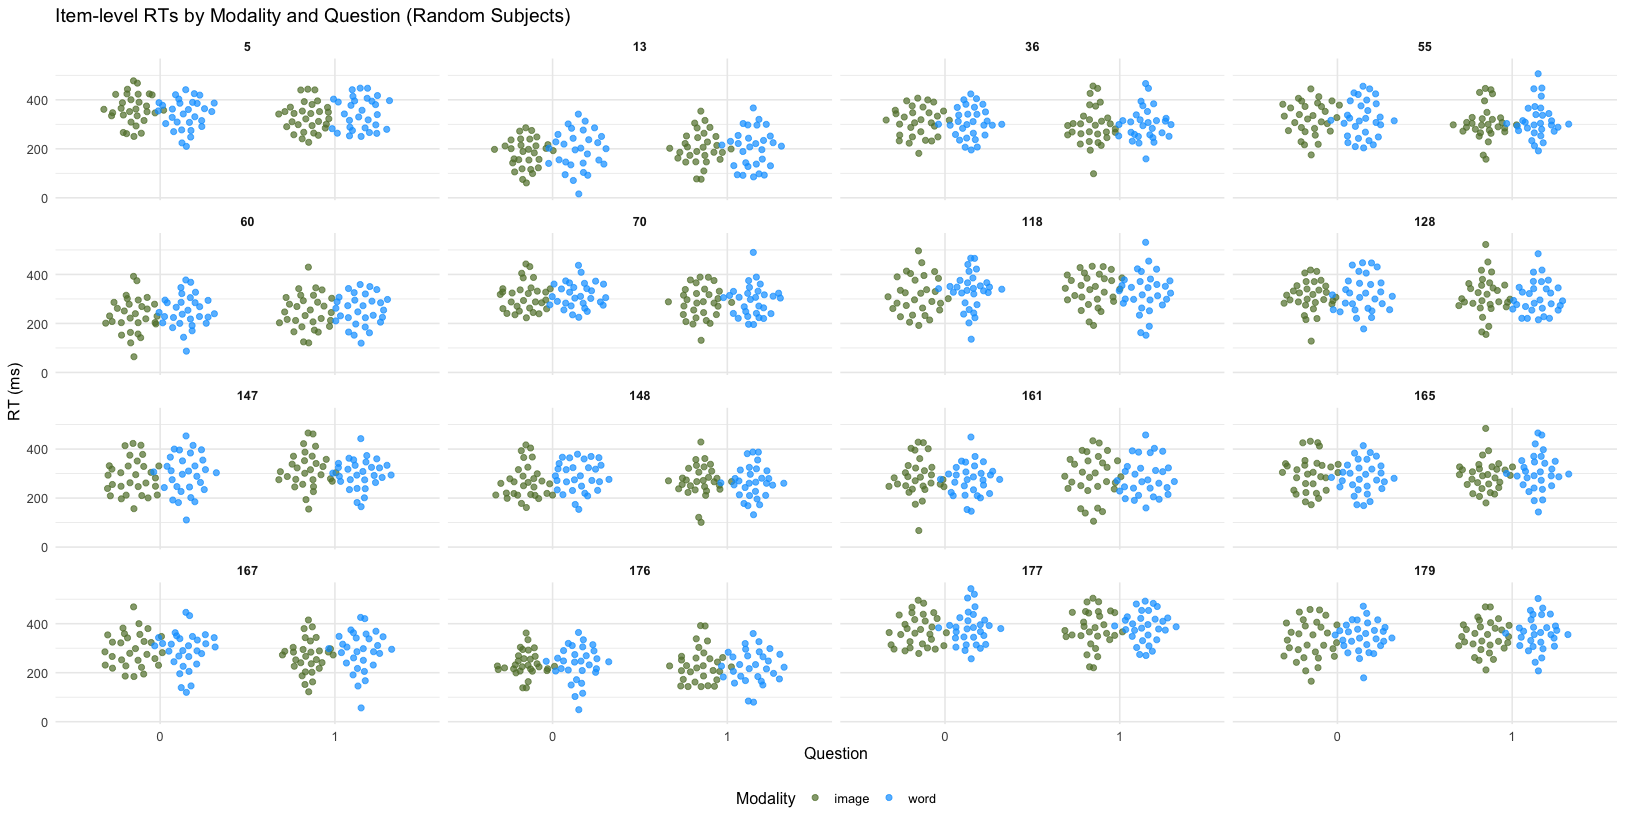

Here is the accompanying R code

```r
library(ggplot2, quietly = T)
library(ggbeeswarm, quietly = T)
library(tidyverse, quietly = T)

set.seed(44)
selected_subjects <- sample(unique(all_data$subject), 16)
question_labels <- c("0" = "1000yrs", "1" = "sound")
modality_colors <- c(
  word = rgb(0, 161, 255, maxColorValue = 255),
  image = rgb(96, 126, 54, maxColorValue = 255)
)


all_data <- data.frame(read.csv("wiscs_data.csv"))

# --- Compute subject-wise means ---
swarm_data2 <- all_data %>%
  group_by(subject, modality, question) %>%
  summarise(mean_rt = mean(rt, na.rm = TRUE), .groups = "drop")

# --- Compute mean ± 3*SD per modality ---
modality_stats <- swarm_data2 %>%
  group_by(modality) %>%
  summarise(
    rt_mean = mean(mean_rt, na.rm = TRUE),
    rt_sd = sd(mean_rt, na.rm = TRUE),
    .groups = "drop"
  )

# --- Join and flag outliers ---
swarm_data_clean <- swarm_data2 %>%
  left_join(modality_stats, by = "modality") %>%
  filter(
    mean_rt >= (rt_mean - 3 * rt_sd),
    mean_rt <= (rt_mean + 3 * rt_sd)
  )

all_data_clean <- all_data %>%
  semi_join(swarm_data_clean, by = c("subject", "modality", "question"))

plot_data <- all_data_clean %>%
  filter(subject %in% selected_subjects) %>%
  mutate(
    question = factor(question),
    modality = factor(modality)
  )

ggplot(plot_data, aes(x = question, y = rt, color = modality)) +
  geom_quasirandom(
    dodge.width = 0.6, width = 0.2, size = 1.8, alpha = 0.7
  ) +
  facet_wrap(~subject, ncol = 4) +
  scale_color_manual(values = modality_colors) +
  labs(
    x = "Question",
    y = "RT (ms)",
    color = "Modality",
    title = "Item-level RTs by Modality and Question (Random Subjects)"
  ) +
  theme_minimal(base_size = 12) +
  theme(
    legend.position = "bottom",
    strip.text = element_text(face = "bold")
  )
```

## What's next? 

Currently, the `wiscs` framework is does not have the flexibility to simulate order effects, so we will do it post-hoc on our dataset!

## How are order effects generated?

Order effects will simply be a 1) shift and 2) greater spread (more noise) of the distribution of RTs for the image condition for the question subject's saw first. Half of participants saw `0` first and the other half started with `1`. 250ms will be added to all points in these groups of data.

In [110]:
# make copy of original df
df2 = df.copy()

# split groups and assign tag
np.random.seed(44)
subjects = df2['subject'].unique()
tags = np.random.choice([0, 1], size=len(subjects))
subject_tags = dict(zip(subjects, tags))
df2['tag'] = df2['subject'].map(subject_tags)

# function to generate order effects
def shift_rt(row, shift=300, noise_sd=50):
    if row['modality'] == 'image' and row['question'] == row['tag']:
        return row['rt'] + shift + np.random.normal(0, noise_sd)
    else:
        return row['rt']

# add order effects
df2['rt'] = df2.apply(shift_rt, axis=1)


In [111]:
df2.to_csv("wiscs_data_ordere.csv", index=False)

## Here's what order effects look like!

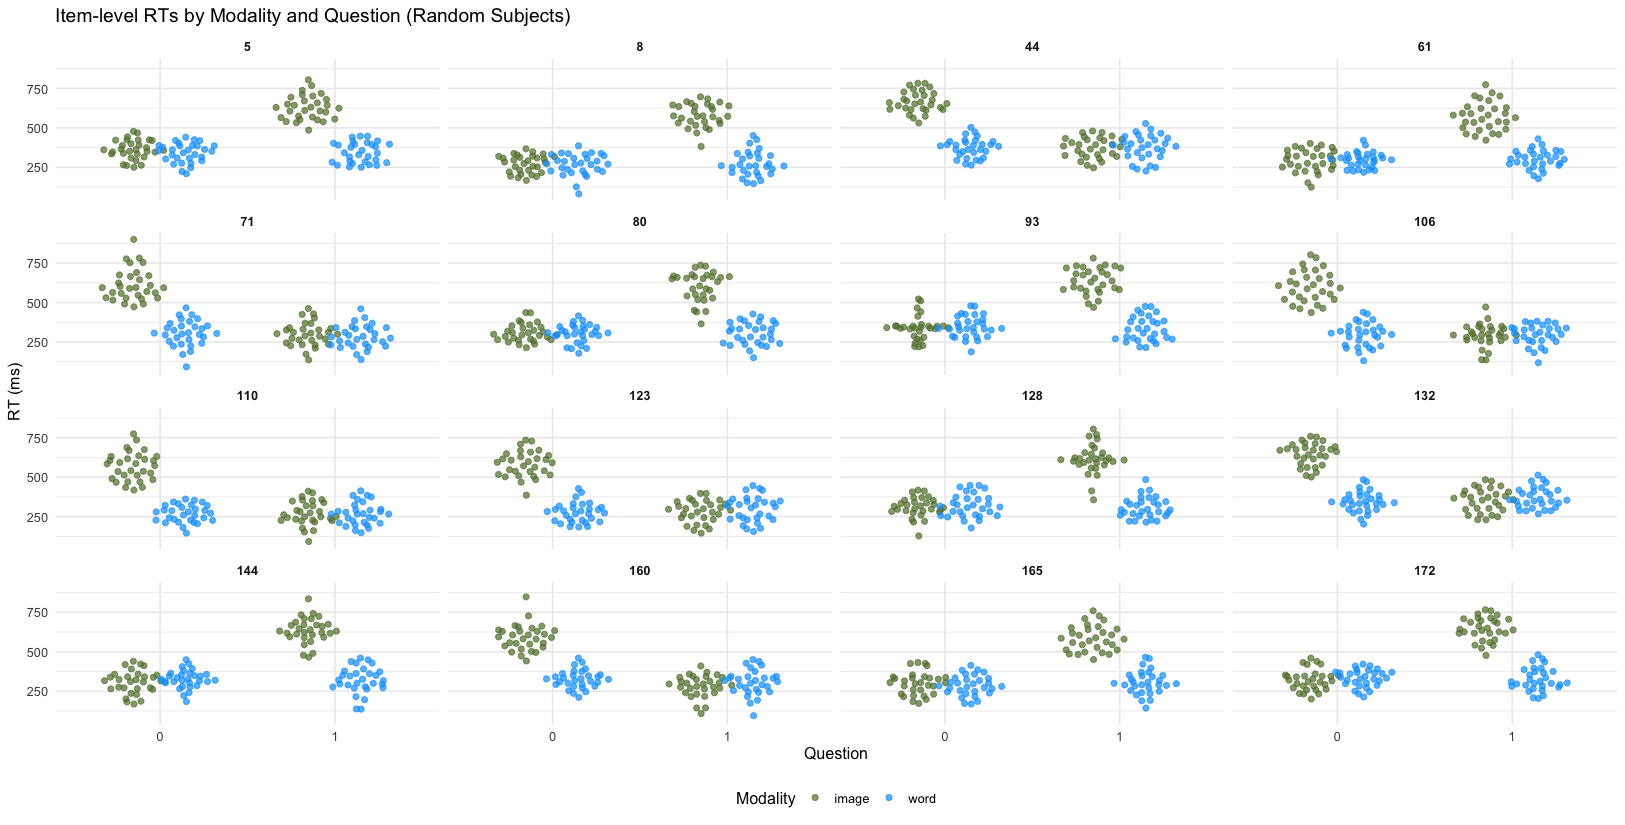

## Let's test our linear model on data with _no_ order effects

In [60]:
df2.head(15)

,subject,rt,question,item,modality,tag
0,0,579.657463,0,0,image,0
1,0,280.425475,0,1,image,0
2,0,419.515185,0,2,image,0
3,0,204.179694,0,3,image,0
4,0,407.175236,0,4,image,0
5,0,38.321285,0,5,image,0
6,0,309.320925,0,6,image,0
7,0,181.148496,0,7,image,0
8,0,701.684335,0,8,image,0
9,0,377.400002,0,9,image,0


In [93]:
code = f"""df <- {to_r(df)}
    # load libraries
    library(lme4)

    # factorize + treatment coding
    df$question <- as.factor(df$question)
    df$subject <- as.factor(df$subject)
    df$item <- as.factor(df$item)
    df$modality <- factor(df$modality, levels = c("word", "image"))
    contrasts(df$modality) <- c(-0.5, 0.5)

    #  set reference levels
    df$question <- relevel(df$question, ref = "0")
    df$item <- relevel(df$item, ref = "0")

    # model
    control <- lmerControl(optimizer = "bobyqa", check.conv.singular = "ignore") # suppress singular fit warnings
    shared <- lmer(rt ~ modality + question + (1 + question | subject) + (1 + question | item), data = df, REML = FALSE, control = control) # nolint
    separate <- lmer(rt ~ modality * question + (1 + question | subject) + (1 + question | item), data = df, REML = FALSE, control = control) # nolint

    anova(shared, separate)
"""
R(code)

Loading required package: Matrix


Data: df
Models:
shared: rt ~ modality + question + (1 + question | subject) + (1 + question | item)
separate: rt ~ modality * question + (1 + question | subject) + (1 + question | item)
         npar    AIC    BIC  logLik -2*log(L)  Chisq Df Pr(>Chisq)
shared     10 231352 231432 -115666    231332                     
separate   11 231354 231442 -115666    231332 0.0955  1     0.7573


## Testing our linear model _with_ and _without_ tag as predictor

In [ ]:
### WITH `tag` ###
code = f"""df <- {to_r(df2)}
    # load libraries
    library(lme4)

    # factorize + treatment coding
    df$question <- as.factor(df$question)
    df$subject <- as.factor(df$subject)
    df$item <- as.factor(df$item)
    df$modality <- factor(df$modality, levels = c("word", "image"))
    df$tag <- as.factor(df$tag)
    contrasts(df$modality) <- c(-0.5, 0.5)

    #  set reference levels
    df$question <- relevel(df$question, ref = "0")
    df$item <- relevel(df$item, ref = "0")

    # # model
    control <- lmerControl(optimizer = "bobyqa", check.conv.singular = "ignore") # suppress singular fit warnings
    shared <- lmer(rt ~ modality + question + tag + (1 + question | subject) + (1 + question | item), data = df, REML = FALSE, control = control) # nolint
    separate <- lmer(rt ~ modality * question + tag + (1 + question | subject) + (1 + question | item), data = df, REML = FALSE, control = control) # nolint

    anova(shared, separate)
"""
R(code)

Loading required package: Matrix


Data: df
Models:
shared: rt ~ modality + question + tag + (1 + question | subject) + (1 + question + tag | item)
separate: rt ~ modality * question + tag + (1 + question | subject) + (1 + question + tag | item)
         npar    AIC    BIC  logLik -2*log(L)  Chisq Df Pr(>Chisq)
shared     14 249436 249548 -124704    249408                     
separate   15 249438 249557 -124704    249408 0.8302  1     0.3622


In [95]:
### WITHOUT `tag` ###
code = f"""df <- {to_r(df2)}
    # load libraries
    library(lme4)

    # factorize + treatment coding
    df$question <- as.factor(df$question)
    df$subject <- as.factor(df$subject)
    df$item <- as.factor(df$item)
    df$modality <- factor(df$modality, levels = c("word", "image"))
    df$tag <- as.factor(df$tag)
    contrasts(df$modality) <- c(-0.5, 0.5)

    #  set reference levels
    df$question <- relevel(df$question, ref = "0")
    df$item <- relevel(df$item, ref = "0")

    # model
    control <- lmerControl(optimizer = "bobyqa", check.conv.singular = "ignore") # suppress singular fit warnings
    shared <- lmer(rt ~ modality + question + (1 + question | subject) + (1 + question | item), data = df, REML = FALSE, control = control) # nolint
    separate <- lmer(rt ~ modality * question + (1 + question | subject) + (1 + question | item), data = df, REML = FALSE, control = control) # nolint

    anova(shared, separate)
"""
R(code)

Loading required package: Matrix


Data: df
Models:
shared: rt ~ modality + question + (1 + question | subject) + (1 + question | item)
separate: rt ~ modality * question + (1 + question | subject) + (1 + question | item)
         npar    AIC    BIC  logLik -2*log(L)  Chisq Df Pr(>Chisq)
shared     10 249431 249510 -124705    249411                     
separate   11 249432 249520 -124705    249410 0.8301  1     0.3622


## Directly comparing `tag`

In [96]:
### Directly comparing `tag` ###
code = f"""df <- {to_r(df2)}
    # load libraries
    library(lme4)

    # factorize + treatment coding
    df$question <- as.factor(df$question)
    df$subject <- as.factor(df$subject)
    df$item <- as.factor(df$item)
    df$modality <- factor(df$modality, levels = c("word", "image"))
    df$tag <- as.factor(df$tag)
    contrasts(df$modality) <- c(-0.5, 0.5)

    #  set reference levels
    df$question <- relevel(df$question, ref = "0")
    df$item <- relevel(df$item, ref = "0")

    # model
    control <- lmerControl(optimizer = "bobyqa", check.conv.singular = "ignore") # suppress singular fit warnings
    with <- lmer(rt ~ modality + question + tag + (1 + question | subject) + (1 + question | item), data = df, REML = FALSE, control = control) # nolint
    without <- lmer(rt ~ modality + question + (1 + question | subject) + (1 + question | item), data = df, REML = FALSE, control = control) # nolint

    anova(with, without)
"""
R(code)

Loading required package: Matrix


Data: df
Models:
without: rt ~ modality + question + (1 + question | subject) + (1 + question | item)
with: rt ~ modality + question + tag + (1 + question | subject) + (1 + question | item)
        npar    AIC    BIC  logLik -2*log(L)  Chisq Df Pr(>Chisq)
without   10 249431 249510 -124705    249411                     
with      11 249433 249520 -124705    249411 0.0182  1     0.8926


## What's going on?

Based on these simulated data, it seems like the incluesion of order effects does not account for much of the interaction. Not sure why, since an interaction is present at the individual subject level. 

## Applying order effects to a proportion of subjects

In [99]:
df3 = df.copy()
np.random.seed(44)
subjects = df3['subject'].unique()
tags = np.random.choice([0, 1], size=len(subjects))
subject_tags = dict(zip(subjects, tags))
df3['tag'] = df3['subject'].map(subject_tags)

# subset subjects to receive the order effect
proportion_with_effect = 0.5
n_effect = int(proportion_with_effect * len(subjects))
np.random.seed(99)
subjects_with_effect = np.random.choice(subjects, size=n_effect, replace=False)
subjects_with_effect = set(subjects_with_effect)

# function to apply order effect only to some participants
def shift_rt(row, shift=200, noise_sd=50):
    if (
        row['subject'] in subjects_with_effect and
        row['modality'] == 'image' and
        row['question'] == row['tag']
    ):
        return row['rt'] + shift + np.random.normal(0, noise_sd)
    else:
        return row['rt']

# Apply order effect
df3['rt'] = df3.apply(shift_rt, axis=1)

In [100]:
df3.to_csv("wiscs_data_ordere2.csv", index=False)

## Redoing model comparisons

In [109]:
### WITH `tag` ###
code = f"""df <- {to_r(df3)}
    # load libraries
    library(lme4)

    # factorize + treatment coding
    df$question <- as.factor(df$question)
    df$subject <- as.factor(df$subject)
    df$item <- as.factor(df$item)
    df$modality <- factor(df$modality, levels = c("word", "image"))
    df$tag <- as.factor(df$tag)
    contrasts(df$modality) <- c(-0.5, 0.5)

    #  set reference levels
    df$question <- relevel(df$question, ref = "0")
    df$item <- relevel(df$item, ref = "0")

    # # model
    control <- lmerControl(optimizer = "bobyqa", check.conv.singular = "ignore") # suppress singular fit warnings
    shared <- lmer(rt ~ modality + question + tag + (1 + question | subject) + (1 + question | item), data = df, REML = FALSE, control = control) # nolint
    separate <- lmer(rt ~ modality * question + tag + (1 + question | subject) + (1 + question | item), data = df, REML = FALSE, control = control) # nolint

    anova(shared, separate)
"""
R(code)

Loading required package: Matrix


Data: df
Models:
shared: rt ~ modality + question + tag + (1 + question | subject) + (1 + question | item)
separate: rt ~ modality * question + tag + (1 + question | subject) + (1 + question | item)
         npar    AIC    BIC  logLik -2*log(L)  Chisq Df Pr(>Chisq)  
shared     11 245645 245733 -122811    245623                       
separate   12 245643 245739 -122810    245619 3.6152  1    0.05725 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [104]:
### WITHOUT `tag` ###
code = f"""df <- {to_r(df3)}
    # load libraries
    library(lme4)

    # factorize + treatment coding
    df$question <- as.factor(df$question)
    df$subject <- as.factor(df$subject)
    df$item <- as.factor(df$item)
    df$modality <- factor(df$modality, levels = c("word", "image"))
    df$tag <- as.factor(df$tag)
    contrasts(df$modality) <- c(-0.5, 0.5)

    #  set reference levels
    df$question <- relevel(df$question, ref = "0")
    df$item <- relevel(df$item, ref = "0")

    # model
    control <- lmerControl(optimizer = "bobyqa", check.conv.singular = "ignore") # suppress singular fit warnings
    shared <- lmer(rt ~ modality + question + (1 + question | subject) + (1 + question | item), data = df, REML = FALSE, control = control) # nolint
    separate <- lmer(rt ~ modality * question + (1 + question | subject) + (1 + question | item), data = df, REML = FALSE, control = control) # nolint

    anova(shared, separate)
"""
R(code)

Loading required package: Matrix


Data: df
Models:
shared: rt ~ modality + question + (1 + question | subject) + (1 + question | item)
separate: rt ~ modality * question + (1 + question | subject) + (1 + question | item)
         npar    AIC    BIC  logLik -2*log(L)  Chisq Df Pr(>Chisq)  
shared     10 245644 245724 -122812    245624                       
separate   11 245642 245730 -122810    245620 3.6152  1    0.05725 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [108]:
### Directly comparing `tag` ###
code = f"""df <- {to_r(df3)}
    # load libraries
    library(lme4)

    # factorize + treatment coding
    df$question <- as.factor(df$question)
    df$subject <- as.factor(df$subject)
    df$item <- as.factor(df$item)
    df$modality <- factor(df$modality, levels = c("word", "image"))
    df$tag <- as.factor(df$tag)
    contrasts(df$modality) <- c(-0.5, 0.5)

    #  set reference levels
    df$question <- relevel(df$question, ref = "0")
    df$item <- relevel(df$item, ref = "0")

    # model
    control <- lmerControl(optimizer = "bobyqa", check.conv.singular = "ignore") # suppress singular fit warnings
    with <- lmer(rt ~ modality + question + tag+ (1 + question | subject) + (1 + question | item), data = df, REML = FALSE, control = control) # nolint
    without <- lmer(rt ~ modality + question + (1 + question | subject) + (1 + question | item), data = df, REML = FALSE, control = control) # nolint

    anova(with, without)
"""
R(code)

Loading required package: Matrix


Data: df
Models:
without: rt ~ modality + question + (1 + question | subject) + (1 + question | item)
with: rt ~ modality + question + tag + (1 + question | subject) + (1 + question | item)
        npar    AIC    BIC  logLik -2*log(L)  Chisq Df Pr(>Chisq)
without   10 245644 245724 -122812    245624                     
with      11 245645 245733 -122811    245623 1.2579  1      0.262
